In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 7.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import os
import random
from collections import Counter
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset,random_split,SubsetRandomSampler, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
def seed_everything(seed=3407):
    """
    Seed everything to make all operations in PyTorch (and other libraries) deterministic.
    Args:
        seed (int): Seed value to set.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_cont = torch.tensor(self.dataframe.iloc[idx]['X_cont'], dtype=torch.float32)

        other_cols = self.dataframe.drop(columns=['label', 'X_cont','Unit1'])
        x_other = torch.tensor(other_cols.iloc[idx].values, dtype=torch.float32)

        label = torch.tensor(self.dataframe.iloc[idx]['label'], dtype=torch.long)

        return x_cont, x_other, label

In [ ]:
class BayesianLSTM(nn.Module):
    def __init__(self, dyn_channels=5, stat_channels=32, hidden_size=50, num_layers=2):
        super(BayesianLSTM, self).__init__()
        # lstm part
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(dyn_channels, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, 15)

        # fc part
        self.fc_static1 = nn.Linear(stat_channels,30)
        self.fc_static2 = nn.Linear(30,15)

        # fusion part
        self.fc_final1 = nn.Linear(30,2)
        #self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x_dynamic, x_static):
        h0 = torch.zeros(self.num_layers, x_dynamic.size(0), self.hidden_size).to(x_dynamic.device)
        c0 = torch.zeros(self.num_layers, x_dynamic.size(0), self.hidden_size).to(x_dynamic.device)
        out1, _ = self.lstm(x_dynamic, (h0, c0))
        out1 = self.relu(self.fc1(out1[:, -1, :]))
        out1 = self.relu(self.fc2(out1))

        out2 = self.relu(self.fc_static1(x_static))
        out2 = self.relu(self.fc_static2(out2))

        out = torch.cat((out1, out2), dim=1)
        out = self.fc_final1(out)

        return out
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = BayesianLSTM(dyn_channels=5, stat_channels=32, hidden_size=50, num_layers=2).to(device)
net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/lstm.pth',map_location=torch.device('cpu')))
softmax = nn.Softmax(dim=1)
def model(x_dynamic, x_static, y=None):
        # Define prior distributions for all neural network weights

        fc_final1w_prior = dist.Normal(loc=torch.zeros_like(net.fc_final1.weight).to(device), scale=3*torch.ones_like(net.fc_final1.weight).to(device)).to_event(2)
        fc_final1b_prior = dist.Normal(loc=torch.zeros_like(net.fc_final1.bias).to(device), scale=0.2*torch.ones_like(net.fc_final1.bias).to(device)).to_event(1)


        model_priors = {

            'fc_final1.weight': fc_final1w_prior, 'fc_final1.bias': fc_final1b_prior

        }
        lifted_module = pyro.random_module("module", net, model_priors)  # Lift module parameters to random variables
        lifted_reg_model = lifted_module()
        #with pyro.plate("data", x_dynamic.size(0)):
        lhat = softmax(lifted_reg_model(x_dynamic, x_static))
        if y is not None:
                y = y.float()
        pyro.sample("obs", dist.Categorical(logits=lhat).to_event(1), obs=y)
        return lhat


# Defining the guide function for variational inference
softplus = torch.nn.Softplus()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def guide(x_dynamic, x_static, y=None):
        # Define variational distributions for the parameters (learnable)
        #softplus = torch.nn.Softplus()

        fc_final1w_mu = torch.randn_like(net.fc_final1.weight)
        fc_final1w_sigma = torch.randn_like(net.fc_final1.weight)
        fc_final1w_mu_param = pyro.param("fc_final1w_mu", fc_final1w_mu).to(device)
        fc_final1w_sigma_param = softplus(pyro.param("fc_final1w_sigma", fc_final1w_sigma).to(device))
        fc_final1w_prior = dist.Normal(loc=fc_final1w_mu_param, scale=fc_final1w_sigma_param).to_event(2)
        fc_final1b_mu = torch.randn_like(net.fc_final1.bias)
        fc_final1b_sigma = torch.randn_like(net.fc_final1.bias)
        fc_final1b_mu_param = pyro.param("fc_final1b_mu", fc_final1b_mu).to(device)
        fc_final1b_sigma_param = softplus(pyro.param("fc_final1b_sigma", fc_final1b_sigma).to(device))
        fc_final1b_prior = dist.Normal(loc=fc_final1b_mu_param, scale=fc_final1b_sigma_param).to_event(1)

        guide_priors = {'fc_final1.weight': fc_final1w_prior, 'fc_final1.bias': fc_final1b_prior}
        lifted_module = pyro.random_module("module", net, guide_priors)
        return lifted_module().to(device)

In [ ]:
trainval_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/train.pkl').reset_index(drop=True)

class_0 = trainval_df[trainval_df['label'] == 0]
class_1 = trainval_df[trainval_df['label'] == 1]
n_samples = len(class_1)
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
train_df = df_balanced.reset_index(drop=True)

N = len(train_df)
train_df = train_df.sample(frac=1).reset_index(drop=True)
val = train_df[:int(N*0.2)]
train_df = train_df[int(N*0.2):]
train_df.fillna(value=np.pi, inplace=True)
val.fillna(value=np.pi, inplace=True)

In [ ]:
print(train_df.shape)
print(val.shape)

(28245, 35)
(7061, 35)


In [ ]:
train_dataset = SequenceDataset(train_df)
valid_dataset = SequenceDataset(val)
train_num = len(train_dataset)
val_num = len(valid_dataset)
batch_size=20
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw, drop_last=True)

print("using {} samples for training, {} samples for validation.".format(train_num,
                                                                           val_num))

Using 8 dataloader workers every process
using 28245 samples for training, 7061 samples for validation.


In [ ]:
sample = train_dataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2])
for x_dynamic, x_static, y in train_loader:
    print(x_dynamic.shape)
    print(x_static.shape)
    print(y.shape)
    break

torch.Size([10, 5])
torch.Size([32])
tensor(0)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([20, 10, 5])
torch.Size([20, 32])
torch.Size([20])


In [ ]:
num_samples = 20

def predict(x_dynamic, x_static):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x_dynamic, x_static).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    #print(mean.numpy())
    return np.argmax(mean.cpu().numpy(), axis=1)#(mean > 0.5).float().reshape(-1)'''
'''
from pyro.infer import Predictive
def predict(x_dynamic, x_static, model, guide, num_samples=100):
    predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=["obs", "_RETURN"])
    svi_samples = predictive(x_dynamic, x_static)
    #print(svi_samples)
    if '_RETURN' in svi_samples:
        predictions = torch.stack([svi_samples['_RETURN'][i] for i in range(num_samples)])
    else:
        predictions = torch.stack([svi_samples['obs'][i].float() for i in range(num_samples)])
    predicted_probabilities = torch.mean(predictions, dim=0)
    predicted_labels = predicted_probabilities.argmax(dim=-1)
    return predicted_labels'''

'\nfrom pyro.infer import Predictive\ndef predict(x_dynamic, x_static, model, guide, num_samples=100):\n    predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=["obs", "_RETURN"])\n    svi_samples = predictive(x_dynamic, x_static)\n    #print(svi_samples)\n    if \'_RETURN\' in svi_samples:\n        predictions = torch.stack([svi_samples[\'_RETURN\'][i] for i in range(num_samples)])\n    else:\n        predictions = torch.stack([svi_samples[\'obs\'][i].float() for i in range(num_samples)])\n    predicted_probabilities = torch.mean(predictions, dim=0)\n    predicted_labels = predicted_probabilities.argmax(dim=-1)\n    return predicted_labels'

In [ ]:
def train(model, guide, train_loader, valid_loader, num_epochs=30):

    optim = Adam({"lr":5e-4})
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    #model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total_train = 0
        for x_dynamic, x_static, y in train_loader:

            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            #print(x_dynamic.shape)
            loss = svi.step(x_dynamic, x_static, y)
            total_loss += loss

            with torch.no_grad():
                #lifted_module = model.guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static)
                #print(f"the prediction prob is:{pred.reshape(-1)}")
                #pred = torch.sigmoid(pred)
            #pred_label = (pred > 0.5).float()
            #print(type(pred_label))
            correct += (pred_label.reshape(-1) == y.cpu().numpy().reshape(-1)).astype(int).sum().item()
            total_train += y.shape[0]
            #print(pred_label.reshape(-1))
            #print(y.shape[0])
        epoch_loss = total_loss / total_train
        epoch_accuracy = correct / total_train
        train_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}")
        train_loss_list.append(epoch_loss)

        total_loss = 0
        correct = 0
        total = 0
        for x_dynamic, x_static, y_val in valid_loader:
            #model.eval()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y_val = y_val.cuda()
            with torch.no_grad():
                loss = svi.evaluate_loss(x_dynamic, x_static, y_val)
                total_loss += loss
                #lifted_module = model.guide(x_dynamic, x_static, y)
                pred_label = predict(x_dynamic, x_static)
                #print(pred)
                #pred = torch.sigmoid(pred)
                #pred_label = (pred > 0.5).float()
                total += y_val.shape[0]
                correct += (pred_label.reshape(-1) == y_val.cpu().numpy().reshape(-1)).astype(int).sum().item()

            epoch_loss = total_loss / total
        epoch_accuracy = correct / total
        valid_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_accuracy}")
        valid_loss_list.append(epoch_loss)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [ ]:
#net = BayesianLSTM(dyn_channels=5, stat_channels=32, hidden_size=50, num_layers=2)
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(model, guide, train_loader, valid_loader, num_epochs=30)

/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:836: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:


Epoch 1, Train Loss: 4.961062670499087, Train Accuracy: 0.4435198300283286
Epoch 1, Validation Loss: 4.013727839742774, Validation Accuracy: 0.49773371104815867
Epoch 2, Train Loss: 3.315908140115039, Train Accuracy: 0.5603045325779037
Epoch 2, Validation Loss: 2.6168144852851674, Validation Accuracy: 0.6079320113314448
Epoch 3, Train Loss: 2.2300373168572487, Train Accuracy: 0.6119688385269122
Epoch 3, Validation Loss: 1.8876887021591575, Validation Accuracy: 0.6364022662889518
Epoch 4, Train Loss: 1.6205323292475415, Train Accuracy: 0.6446883852691219
Epoch 4, Validation Loss: 1.3833326971902389, Validation Accuracy: 0.6562322946175637
Epoch 5, Train Loss: 1.1966102325998607, Train Accuracy: 0.6489022662889519
Epoch 5, Validation Loss: 1.068200563641513, Validation Accuracy: 0.6563739376770539
Epoch 6, Train Loss: 0.9635647927450475, Train Accuracy: 0.6515580736543909
Epoch 6, Validation Loss: 0.8858267365366473, Validation Accuracy: 0.6617563739376771
Epoch 7, Train Loss: 0.84256516

Text(0.5, 1.0, 'Accuracy curve')

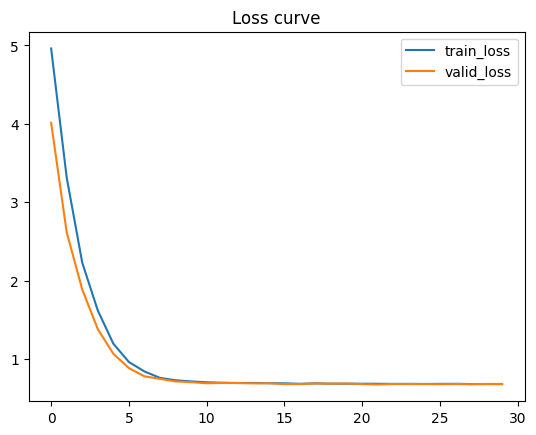

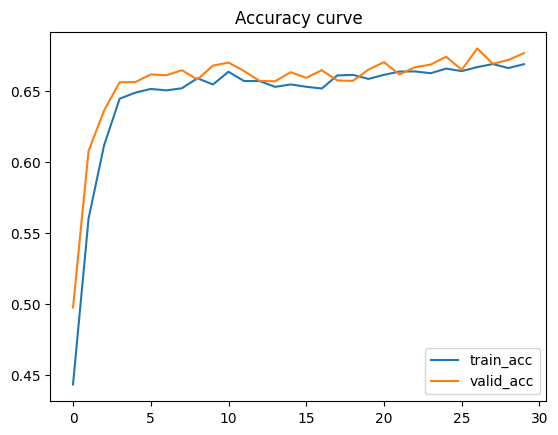

In [ ]:
plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(valid_loss_list, label="valid_loss")
plt.legend()
plt.title(f"Loss curve")

plt.figure()
plt.plot(train_acc_list, label="train_acc")
plt.plot(valid_acc_list, label="valid_acc")
plt.legend()
plt.title(f"Accuracy curve")

In [ ]:
batch_size=20
test_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/test.pkl').reset_index(drop=True)

class_0 = test_df[test_df['label'] == 0]
class_1 = test_df[test_df['label'] == 1]
n_samples = len(class_1)
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
test_df = df_balanced.reset_index(drop=True)

N = len(test_df)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.fillna(value=np.pi, inplace=True)
test_dataset = SequenceDataset(test_df)
test_num = len(test_dataset)


test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = False)

In [ ]:
correct = 0
total = 0
y_true=[]
y_pred=[]
for x_dynamic, x_static, y in test_loader:

            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            y = y.float()

            lifted_module = guide(x_dynamic, x_static, y)
            pred_label = predict(x_dynamic, x_static)
            total += y.shape[0]
            correct += (pred_label.reshape(-1) == y.numpy().reshape(-1)).astype(int).sum().item()
            y_true.append(y.reshape(-1))
            y_pred.append(pred_label.reshape(-1))

print(f"the test accuracy is {correct/total}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:836: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (

the test accuracy is 0.6282664117272148


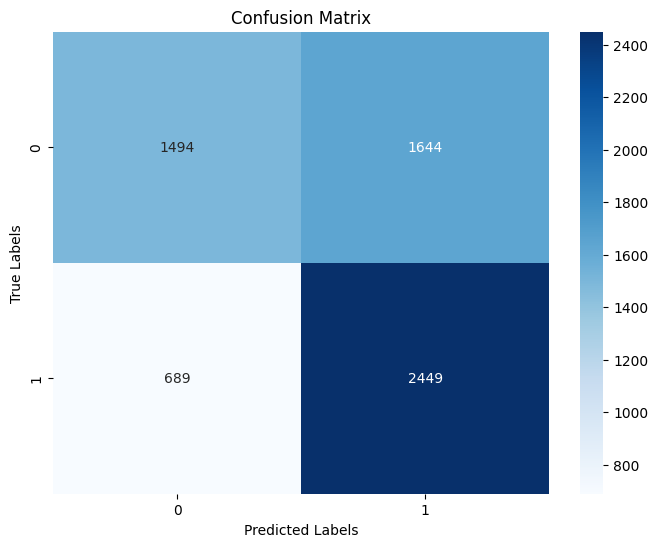

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sns
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
CM = confusion_matrix(y_true, y_pred)
#auc_score = roc_auc_score(y_true, y_prob_list, multi_class='ovr')
plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, fmt="d", cmap='Blues')#, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
torch.save(pyro.get_param_store().get_state(), "/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/pre_lstm_bayesian.pth")


In [ ]:
for name, value in pyro.get_param_store().items():
    print(f"Parameter Name: {name}")
    print(f"Values:\n{value}\n")

Parameter Name: fc_final1w_mu
Values:
tensor([[-4.2368e-02,  5.8053e-02, -6.8383e-02, -2.2297e-02,  3.1385e-02,
         -3.9108e-02, -1.0226e+00,  4.3387e-02, -1.8438e-02,  2.4341e-02,
         -2.8172e-02,  2.3204e-02,  2.7182e-02, -2.6643e-02,  4.4641e-02,
          2.2498e+00,  1.3374e-02, -5.5915e-02,  1.5840e-02,  1.1841e-02,
         -2.3732e-02,  7.1750e-02,  2.6642e-02, -7.2527e-03,  9.9423e-03,
         -3.2083e-02,  2.9472e-02, -6.8221e-03,  6.6450e-03, -1.1710e-02],
        [ 2.0867e-02,  9.6576e-03, -5.1295e-02, -2.8543e-02,  3.5039e-02,
          5.5319e-03,  1.0153e+00, -2.5043e-03,  4.7853e-02,  2.4940e-02,
         -1.1340e-02, -2.8029e-02,  6.3837e-03,  3.9701e-02,  1.5346e-02,
         -1.5237e+00,  9.3494e-03,  8.5795e-03,  2.2432e-02, -2.1552e-03,
         -2.8609e-03, -1.5187e-02, -1.7253e-02,  1.6993e-03, -9.8624e-03,
         -8.1600e-03, -2.3542e-02,  2.1709e-02,  6.0096e-02,  2.5233e-02]],
       requires_grad=True)

Parameter Name: fc_final1w_sigma
Values:
te

In [ ]:
from torch.nn import functional as F
def predict_show(x_dynamic, x_static, num_samples):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.softmax(model(x_dynamic, x_static)).data for model in sampled_models]
    #print(yhats[0].shape)
    mean_list = torch.mean(torch.stack(yhats), 0)
    std_list = torch.std(torch.stack(yhats), 0)
    pred_list = np.argmax(mean_list.cpu().numpy(), axis=1)
    #print(mean.numpy())
    return mean_list, std_list, pred_list

<ipython-input-26-dc0c04cbfad9>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhats = [F.softmax(model(x_dynamic, x_static)).data for model in sampled_models]


torch.Size([20, 2])


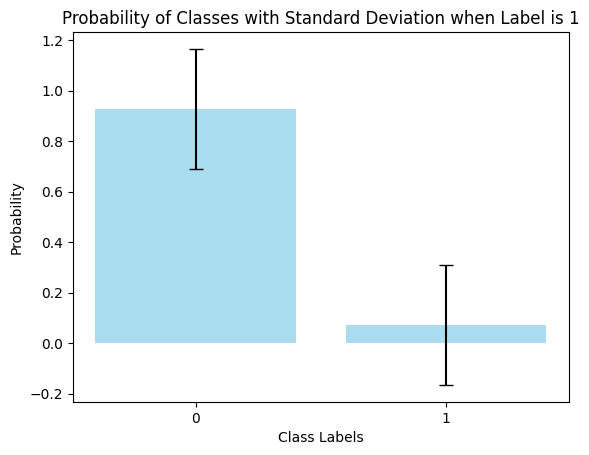

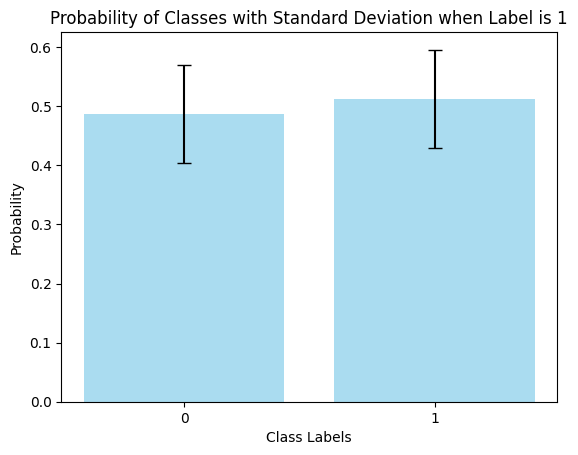

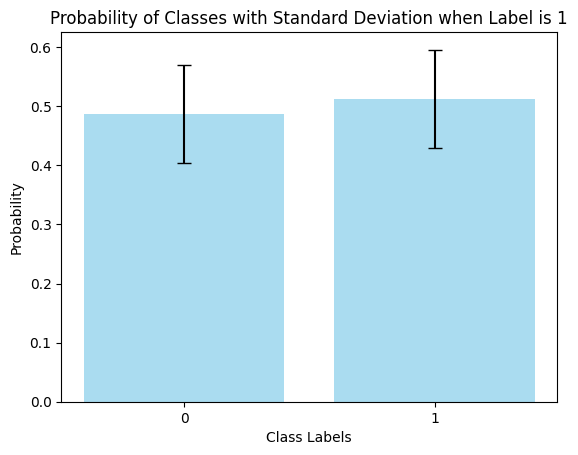

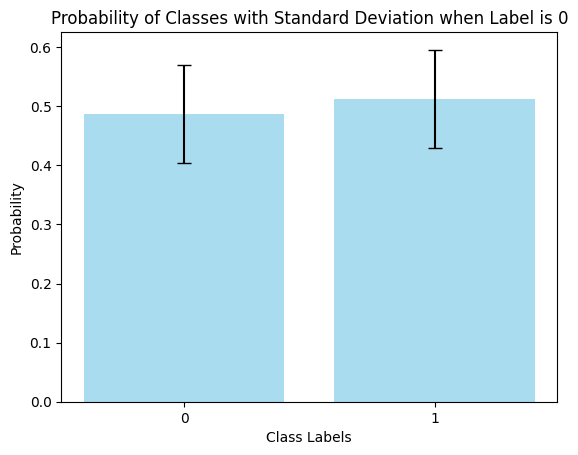

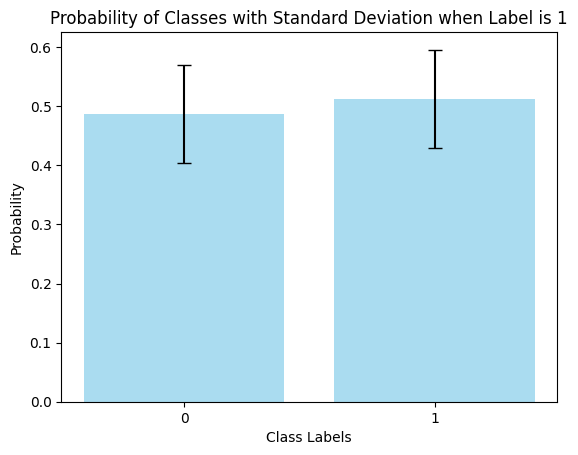

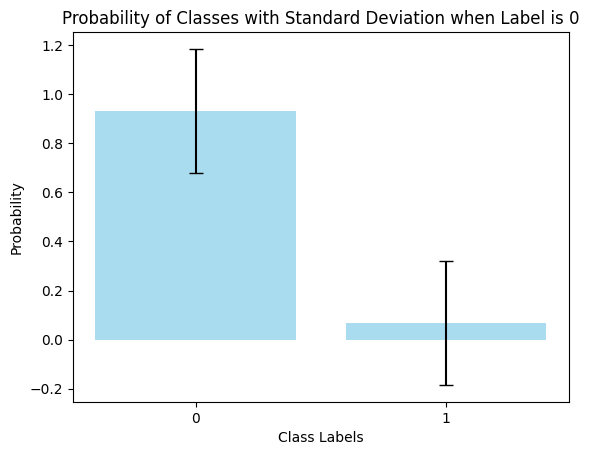

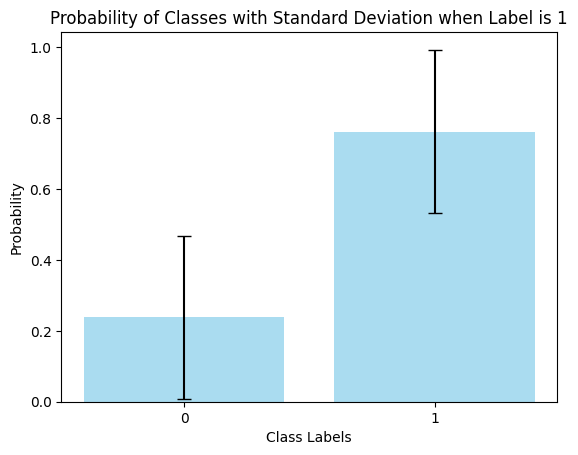

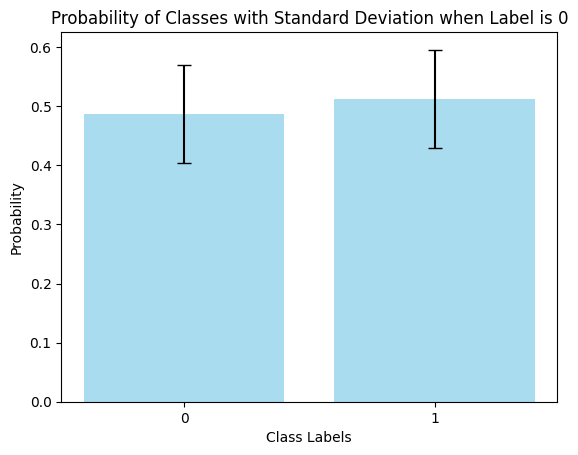

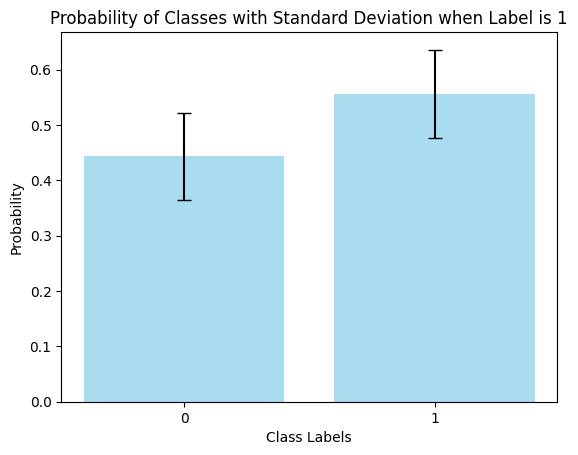

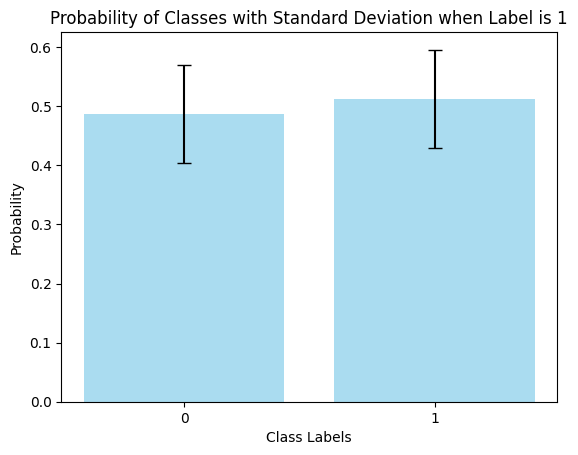

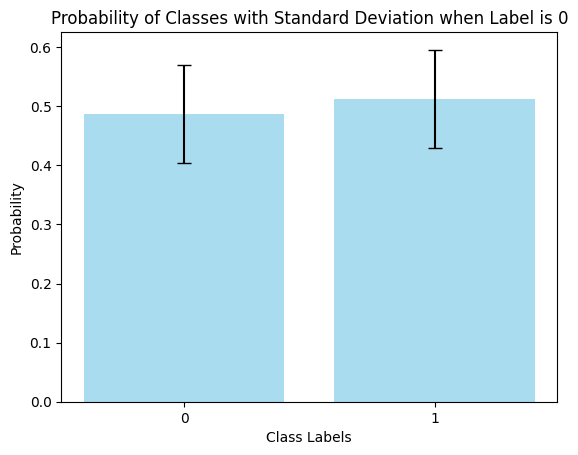

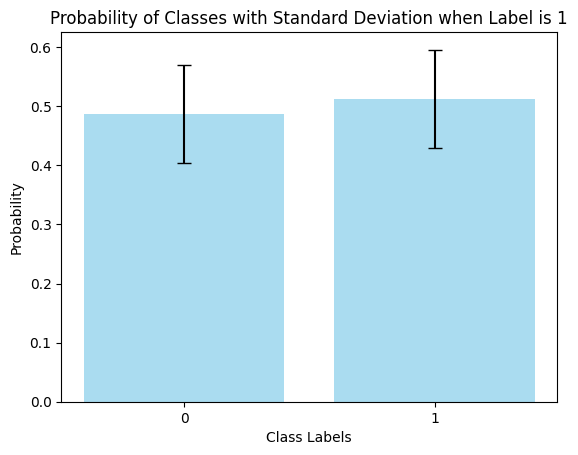

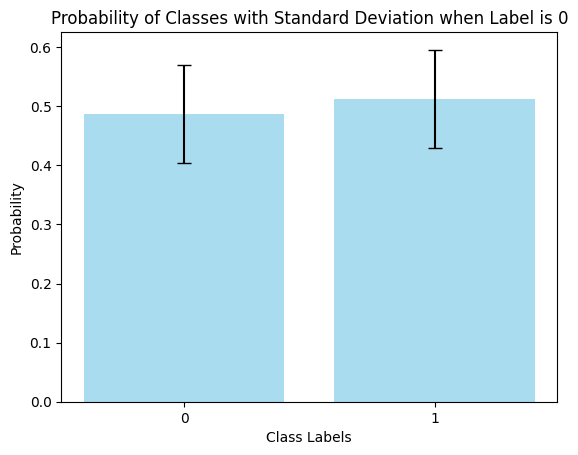

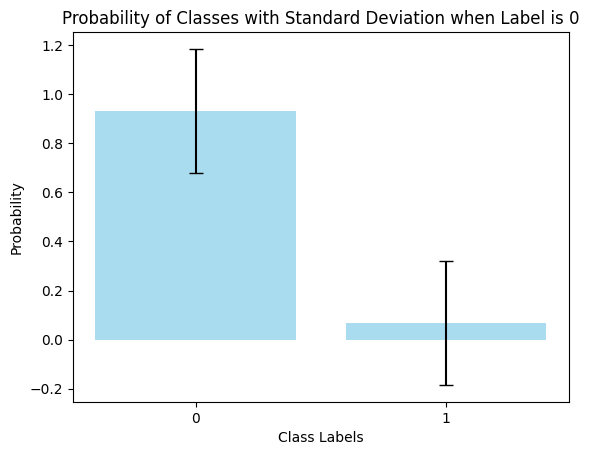

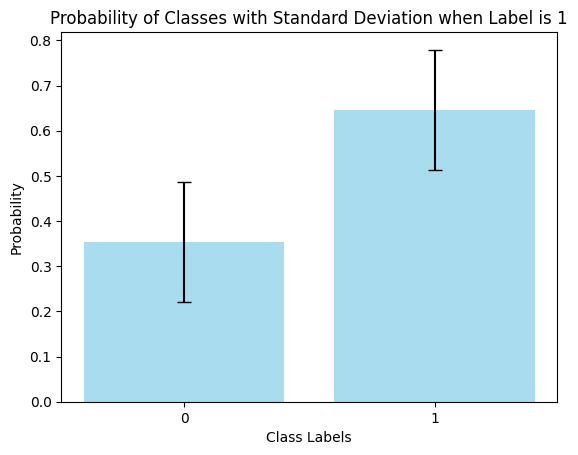

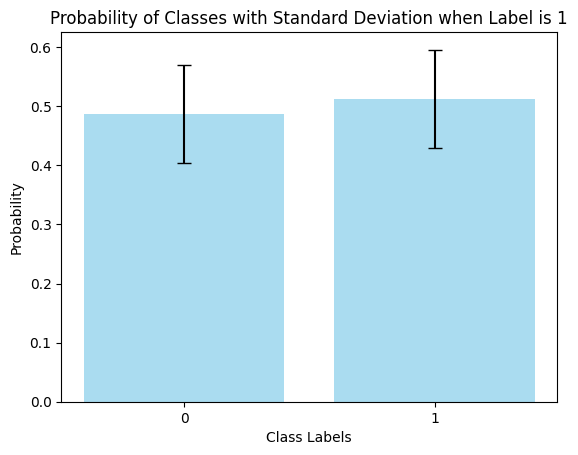

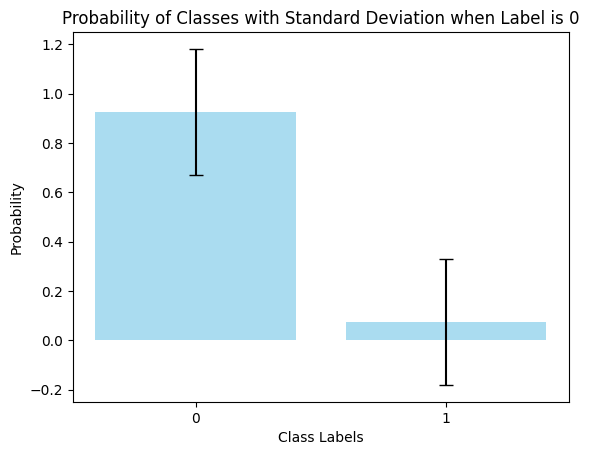

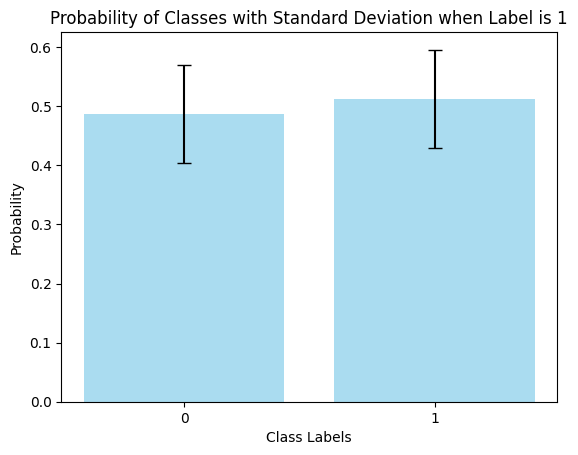

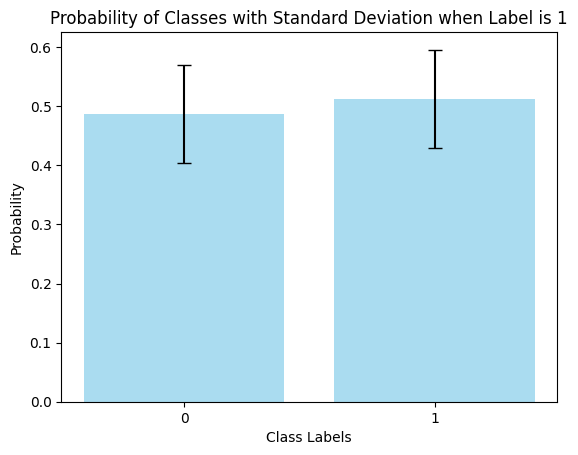

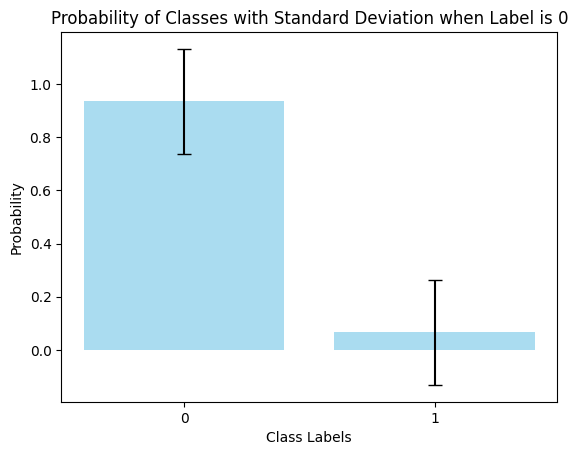

In [ ]:

for x_dynamic, x_static, y_val in valid_loader:
    mean_list, std_list, pred_list = predict_show(x_dynamic, x_static, 30)
    label_list = y_val
    break
for i in range(pred_list.shape[0]):
    means = mean_list[i]
    stds = std_list[i]
    preds = pred_list[i]
    label = label_list[i]
    plt.figure()
    plt.bar([0,1] , means, yerr=stds, capsize=5, color='skyblue', alpha=0.7)
    plt.xlabel('Class Labels')
    plt.ylabel('Probability')
    plt.title(f'Probability of Classes with Standard Deviation when Label is {label}')
    plt.xticks([0,1])  # Ensure x-ticks are only 0 and 1
    plt.show()


In [ ]:
for x_dynamic, x_static, y_val in valid_loader:
    mean_list, std_list, pred_list = predict_show(x_dynamic, x_static, 30)
    break

torch.Size([20, 2])


<ipython-input-21-dc0c04cbfad9>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yhats = [F.softmax(model(x_dynamic, x_static)).data for model in sampled_models]
